In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import dates
from matplotlib.colors import LogNorm
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import scipy.interpolate as interpolate
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats.mstats import scoreatpercentile
import pyart
import os,subprocess,time,copy
import scipy
import math
import matplotlib.gridspec as gridspec
import cPickle as pickle
#import pickle
import pprint
import pyproj
import pandas as pd
import scipy.interpolate as interpolate
import sharppy.sharptab as tab
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level
%matplotlib inline

In [2]:
filenm = '/mnt/raid/afridlin/data/mc3e/citation-nasa-und/data/QC_Processed/20110520_125403/11_05_20_12_54_03.mc3e'
#nev_df = pd.read_table(filenm, delim_whitespace=True, header=[60],skiprows=[61])
nev_df = pd.read_table(filenm, delim_whitespace=True, header=[60,61])
print nev_df.columns

MultiIndex(levels=[[u'2-DC_Conc', u'2-DC_EffRad', u'2-DC_MenD', u'2-DC_VolDia', u'Air_Temp', u'Alpha', u'Beta', u'CABIN_PRES', u'CDP_Conc', u'CDP_EffRad', u'CDP_LWC', u'CDP_MenD', u'CDP_VolDia', u'CPCConc', u'DEWPT', u'DewPoint', u'FrostPoint', u'IAS', u'IceMSOFreq', u'King_LWC_ad', u'MachNo_N', u'MixingRatio', u'Nev_LWCcor', u'Nev_TWC', u'POSZ_Acc', u'POS_Alt', u'POS_Head', u'POS_Lat', u'POS_Lon', u'POS_Pitch', u'POS_Roll', u'POS_Spd', u'POS_Trk', u'Pitot_Wing', u'Pot_Temp_T1', u'Press_Alt', u'STATIC_PR', u'TAS', u'TSG_Date', u'TURB', u'Time', u'VERT_VEL', u'Wind_D', u'Wind_M', u'Wind_Z'], [u'#/cm^3', u'C', u'Hz', u'MPsec', u'MPsec2', u'None', u'cm^2/3*s^-1', u'decK', u'degC', u'degrees', u'g/m^3', u'hPa', u'm', u'm/s', u'ppmw', u'second', u'stamp', u'um']],
           labels=[[40, 4, 20, 17, 37, 35, 34, 33, 7, 36, 14, 21, 15, 16, 30, 29, 26, 24, 27, 28, 25, 31, 32, 5, 6, 41, 44, 43, 42, 39, 19, 23, 22, 8, 10, 11, 12, 9, 0, 2, 3, 1, 18, 13, 38], [15, 8, 5, 13, 13, 12, 7, 11, 11, 11, 8

In [4]:
#..These are first-guess, but are a bit crummy at leg beginning/end
cita_leg0_s = 13.8964   #
cita_leg0_e = 14.0050   #
cita_leg1_s = 14.0358      #
cita_leg1_e = 14.2197      #
cita_leg2_s = 14.2644         #
cita_leg2_e = 14.5422         #
cita_leg3_s = 14.5839      #
cita_leg3_e = 14.6961      #
cita_leg4_s = 14.7292   #
cita_leg4_e = 14.9047   #

In [70]:
#..New start/end times of legs, with end bits chopped. 
#..Altitudes are from the POS system and are meters above MSL
cita_leg0c_s = 13.9014     #..median = 5928.1
cita_leg0c_e = 14.0        #..mean   = 5929.0
cita_leg1c_s = 14.0498        #..median = 6902.0
cita_leg1c_e = 14.2127        #..mean   = 6902.3
cita_leg2c_s = 14.275            #..median = 7876.9
cita_leg2c_e = 14.535            #..mean   = 7877.5
cita_leg3c_s = 14.5889        #..median = 6944.3
cita_leg3c_e = 14.6841        #..mean   = 6945.2
cita_leg4c_s = 14.7432     #..median = 5974.8
cita_leg4c_e = 14.8977     #..mean   = 5975.3

In [77]:
start_time = cita_leg4c_s
end_time   = cita_leg4c_e
# start_time = 14.264
# end_time = 14.542
#start_time = 14.275
#end_time = 14.535
#start_time = cita_leg0_s+.005
#end_time = cita_leg0_e-.005
#start_time = cita_leg1_s+.014
#end_time   = cita_leg1_e-.007
#start_time = cita_leg3_s+.005
#end_time = cita_leg3_e-.012
#start_time = cita_leg4_s+.014
#end_time   = cita_leg4_e-.007
#..

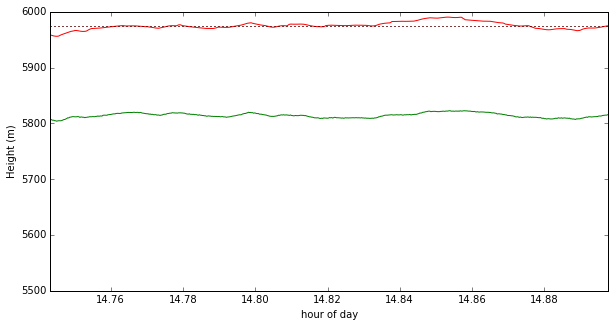

In [78]:
altarr = nev_df['POS_Alt'].values
altalt = nev_df['Press_Alt'].values
timarr = nev_df['Time'].values/3600.
altarr = np.ma.masked_where(altarr>999999.,altarr)
alt_cut = altarr[np.logical_and(timarr>start_time,timarr<end_time)]
#..
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(timarr,altarr,'r')
plt.plot(timarr,altalt,'g')
plt.plot([start_time,end_time],[alt_cut.mean(),alt_cut.mean()],'r:')
plt.plot([start_time,end_time],[np.median(alt_cut),np.median(alt_cut)],'k:')
ax.set_xlim(start_time,end_time)
ax.set_ylim(5500,6000)
#ax.set_ylim(6600,7200)
#ax.set_ylim(7300,8000)
ax.set_xlabel('hour of day')
ax.set_ylabel('Height (m)')

In [79]:
print np.median(alt_cut),alt_cut.mean()

5974.79497 5975.28772619


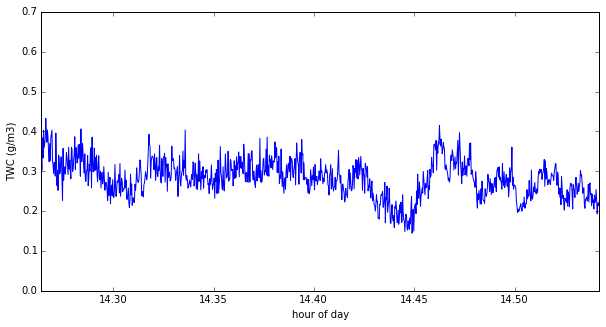

In [4]:
nevarr = nev_df['Nev_TWC'].values
timarr = nev_df['Time'].values/3600.
nevarr = np.ma.masked_where(nevarr>999999.,nevarr)
#..
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(timarr,nevarr)
ax.set_xlim(start_time,end_time)
ax.set_ylim(0,.7)
ax.set_xlabel('hour of day')
ax.set_ylabel('TWC (g/m3)')

In [5]:
nev_cut = nevarr[np.logical_and(timarr>start_time,timarr<end_time)]
timarr_cut = timarr[np.logical_and(timarr>start_time,timarr<end_time)]

In [6]:
#..Now let's compare to Greg's estimates of mass
filenm = '/mnt/raid/afridlin/data/mc3e/citation-mcfarquhar/mc3e.illinois_microphysics.110520_V3withArea.cdf'
nc     = Dataset(filenm,'r')
timm   = nc.variables['time'][:]      #..HHMMSS
d_le   = nc.variables['bin_min'][:]   #..In microns
d_re   = nc.variables['bin_max'][:]   #..In microns
d_mid  = nc.variables['bin_mid'][:]   #..In microns
dD     = nc.variables['bin_dD'][:]/(1.e4)  #..1/um -> 1/cm
dN_dD  = nc.variables['numdist'][:,:]   #..1/cm4
dM_dD  = nc.variables['massdist'][:,:]  #..g/cm4
dM_dD_a = nc.variables['massdist_BL'][:,:] #..Using Baker and Lawson
dA_dD  = nc.variables['areadist'][:,:]  #..cm2/cm4
nc.close()
#..Convert timm to a less esoteric format, in this case decimal UTC hour of day
ntim   = timm.shape[0]
time   = []
for i in range(ntim):
    timst = str(timm[i])
    time  = np.r_[time,float(timst[:2]) + float(timst[2:4])/60. + float(timst[4:])/3600.]
#..
nbin   = d_mid.shape[0]
dlogD  = np.log10(d_re/d_le)
#..
logcon  = np.logical_and(time>start_time,time<end_time)
tim   = time[logcon]
dN_dD = dN_dD[logcon,:]
dM_dD = dM_dD[logcon,:]
dM_dD_a = dM_dD_a[logcon,:]
dA_dD = dA_dD[logcon,:]
#..
dN_dD = np.ma.masked_where(np.isnan(dN_dD),dN_dD)
dM_dD = np.ma.masked_where(np.isnan(dM_dD),dM_dD)
dM_dD_a = np.ma.masked_where(np.isnan(dM_dD_a),dM_dD_a)
dA_dD = np.ma.masked_where(np.isnan(dA_dD),dA_dD)

#..

In [59]:
print tim[100]
print (dM_dD[100,:]*dD*1e6).sum()
print (np.ma.median(dM_dD[:,:],axis=0)*dD*1.e6).sum()
print (np.ma.mean(dM_dD[:,:],axis=0)*dD*1.e6).sum()
print (np.ma.median(dlogD*(dM_dD[:,:]*1.e6*dD/dlogD),axis=0)).sum()

14.7569694444
0.429127560356
0.407112164401
0.429758124839
0.407112164401


In [7]:
mcfq_mass = []
bl_mass = []
for i in range(dM_dD.shape[0]):
    mcfq_mass = np.r_[mcfq_mass,np.sum(dD*dM_dD[i,:])*1.e6]
    bl_mass = np.r_[bl_mass,np.sum(dD*dM_dD_a[i,:])*1.e6]

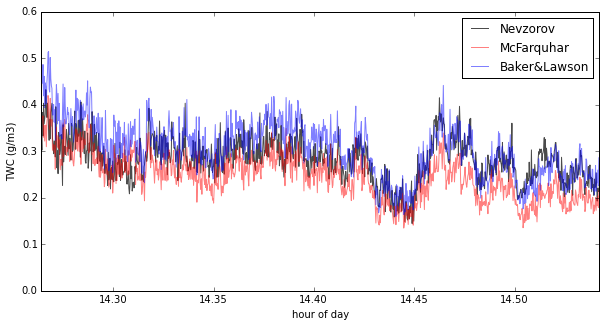

In [23]:
nevarr = nev_df['Nev_TWC'].values
timarr = nev_df['Time'].values/3600.
nevarr = np.ma.masked_where(nevarr>999999.,nevarr)
#..
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(timarr,nevarr,'k',alpha=.7,label = 'Nevzorov')
ax.plot(tim,mcfq_mass,'r',alpha=.5, label = 'McFarquhar')
ax.plot(tim,bl_mass,'b',alpha=.5,label='Baker&Lawson')
ax.set_xlim(start_time,end_time)
ax.set_ylim(0,.6)
ax.set_xlabel('hour of day')
ax.set_ylabel('TWC (g/m3)')
plt.legend()

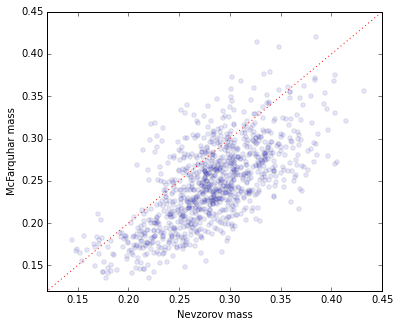

In [35]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.scatter(nev_cut,mcfq_mass,alpha=.1)
ax.plot([0,.5],[0,.5],'r:')
ax.set_xlim(.12,.45)
ax.set_ylim(.12,.45)
ax.set_xlabel('Nevzorov mass')
ax.set_ylabel('McFarquhar mass')

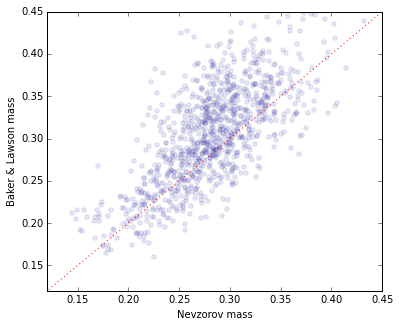

In [37]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.scatter(nev_cut,bl_mass,alpha=.1)
ax.plot([0,.5],[0,.5],'r:')
ax.set_xlim(.12,.45)
ax.set_ylim(.12,.45)
ax.set_xlabel('Nevzorov mass')
ax.set_ylabel('Baker & Lawson mass')

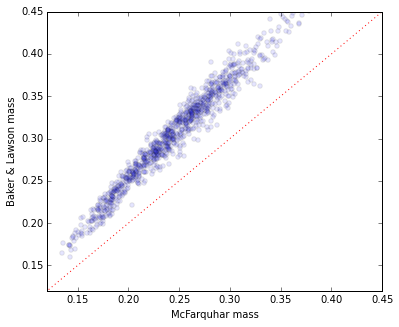

In [34]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.scatter(mcfq_mass,bl_mass,alpha=.1)
ax.plot([0,.5],[0,.5],'r:')
ax.set_xlim(.12,.45)
ax.set_ylim(.12,.45)
ax.set_xlabel('McFarquhar mass')
ax.set_ylabel('Baker & Lawson mass')

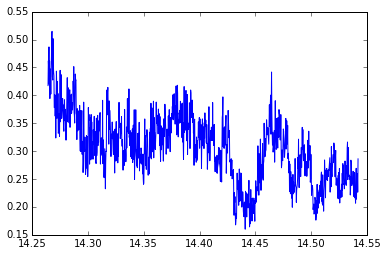

In [13]:
plt.plot(tim,bl_mass)